In [1]:
import sqlalchemy as sql
import pandas as pd
import glob
from os import path, sep
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftshift
from scipy.signal import oaconvolve
from scipy.signal import remez
import time
import decimate as d
from importlib import reload
reload(d);

In [2]:
time.perf_counter()

13124.627910822

In [8]:
f3 = remez(2002,[0., 1, 2., 250.],[1.,0.],fs=500)
f3 = f3[1:-1]

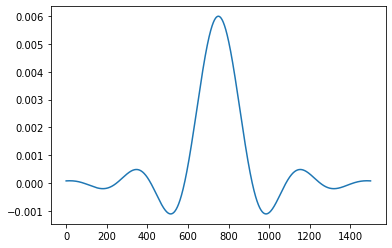

In [17]:
plt.plot(f3[250:1750])

In [10]:
server = "thesis.ca6j6heoraog.eu-central-1.rds.amazonaws.com"
engine = sql.create_engine(f"mysql+pymysql://admin:FphvsYQek4@{server}/thesis_db")

In [11]:
con = engine.connect()

```SQL
create table interpolation_types (
	id int(11) NOT NULL PRIMARY KEY AUTO_INCREMENT,
    interp_algo varchar(45),
    algo_version varchar(20),
    notebook_name varchar(45),
    sampling_rate float(6,4)
    )
```

In [13]:

stmnt ="""
INSERT IGNORE INTO interpolation_series
values 
    (1, "legacy", "", NULL, 0.5),
    (2, "piecewise", "ec31c78", "interpolate and upload", 0.5),
    (3, "piecewise", "716f804", "interpolate and upload", 0.5),
    (4, "piecewise", "716f804", "interpolate and upload", 0.25)

"""

con.execute(stmnt)

/home/siegman/miniconda3/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (1062, "Duplicate entry '1' for key 'PRIMARY'")
  result = self._query(query)
/home/siegman/miniconda3/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (1062, "Duplicate entry '2' for key 'PRIMARY'")
  result = self._query(query)
/home/siegman/miniconda3/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (1062, "Duplicate entry '3' for key 'PRIMARY'")
  result = self._query(query)


In [14]:
stmnt = """
SELECT DISTINCT series_type_id, group_id, participant_id
FROM raw_interval_data
"""

raw_series = con.execute(stmnt)

In [15]:
raw_series

In [16]:
get_series = sql.text("""
SELECT data_time
FROM raw_interval_data
WHERE series_type_id = :sti
AND group_id = :gi
AND participant_id = :pi""")

In [19]:
tref = time.perf_counter()
for series_type_id, group_id, participant_id in raw_series:
    print(series_type_id, group_id, participant_id, np.around(time.perf_counter()-tref,2) ) 
    q = con.execute(get_series, sti=series_type_id, gi= group_id, pi=participant_id)
    t = np.array(q.fetchall()).astype(float).squeeze()
    x = t[:-1] # don't use the point which marks the end of the experiment
    y = np.diff(t)
    x_pw = np.arange(0,t[-1],0.25)
    y_pw = d.pw_constant_convolve(x, y, t[-1], f3, 2, 1.5, x_pw)
    nx = len(x_pw)
    interpolated_data = pd.DataFrame({
        'series_type_id': [series_type_id]*nx,
        'interpolation_series_id': [4]*nx,
        'group_id': [group_id]*nx,
        'participant_id': [participant_id]*nx,
        'data_ordinal': range(nx),
        'data_time': x_pw,
        'data_value': np.around(y_pw,5)
    })
    interpolated_data.to_sql(name='interpolated_interval_data', con=con, if_exists='append', index=False, method='multi')   


1 1001 102 0.0
1 1001 103 0.75
1 1003 108 1.29
1 1003 109 1.81
1 1004 110 2.43
1 1004 111 2.99
1 1004 112 3.57
1 1005 113 4.21
1 1005 114 4.81
1 1005 115 5.41
1 1006 116 5.99
1 1006 117 6.64
1 1006 118 7.22
1 1007 119 7.81
1 1007 120 8.48
1 1007 121 9.07
1 1008 122 9.68
1 1008 123 10.25
1 1008 124 10.91
1 1009 125 11.51
1 1009 126 12.13
1 1009 127 12.79
1 1010 128 13.38
1 1010 129 13.98
1 1010 130 14.56
1 1011 131 15.2
1 1011 132 15.8
1 1011 133 16.37
1 1012 134 17.02
1 1012 135 17.64
1 1012 136 18.23
1 1013 137 18.84
1 1013 138 19.51
1 1013 139 20.17
1 1014 140 20.77
1 1014 141 21.44
1 1014 142 22.08
1 1015 144 23.01
1 1015 145 23.6
1 1016 146 24.24
1 1016 147 24.82
1 1016 148 25.43
1 1017 149 26.08
1 1017 151 26.66
1 1019 155 27.24
1 1019 156 27.83
1 1019 157 28.48
1 1020 158 29.09
1 1020 159 29.67
1 1020 160 30.33
1 1022 164 30.89
1 1022 165 31.47
1 1022 166 32.08
1 1023 167 32.7
1 1023 168 33.24
1 1023 169 33.78
1 1024 170 34.4
1 1024 171 35.16
1 1024 172 35.73
1 1025 173 36.34
1 1

In [ ]:
y_pw = d.pw_constant_convolve(x, y, t[-1], f3, 4, 3, x_pw)
nx = len(x_pw)
interpolated_data = pd.DataFrame({
    'series_type_id': [series_type_id]*nx,
    'group_id': [group_id]*nx,
    'participant_id': [participant_id]*nx,
    'data_ordinal': range(nx),
    'data_time': x_pw,
    'data_value': np.around(y_pw,5)
})
interpolated_data.to_sql(name='interpolated_interval_data', con=con, if_exists='append', index=False, method='multi')   


In [ ]:
df

In [ ]:
(t[-1], f3, 4, 3, x_pw)

In [ ]:
x

In [ ]:
y